In [ ]:
import numpy as np
from scipy.signal import firwin

def generate_hex_coefficients():
    # Configuration
    num_taps = 128
    cutoff_frac = 1.0 / 3.0  # 1/3 of Nyquist frequency
    
    # 1. Design Filter (Windowed Sinc, Hamming window)
    # firwin arguments: num_taps, cutoff (normalized 0.0-1.0 where 1.0 is Nyquist)
    h = firwin(num_taps, cutoff_frac, window='hamming')

    # 2. Scale for Fixed Point Unity Gain
    # In Q15 fixed point, 1.0 is represented by 32768 (or 32767).
    # We scale so the Sum of Coefficients = 32768.
    # This ensures that DC signals (Gain) pass through with a magnitude of 1.0 (in fixed point math).
    target_gain = 32768.0 
    
    current_sum = np.sum(h)
    h_scaled = h * (target_gain / current_sum)
    
    # 3. Quantize to Integers
    h_quantized = np.round(h_scaled).astype(int)
    
    # 4. Correct Summation Error
    # Quantization often results in a sum that is slightly off (e.g., 32767 or 32769)
    # We adjust the center tap to ensure the sum is exactly 32768.
    current_q_sum = np.sum(h_quantized)
    diff = int(target_gain) - current_q_sum
    center_index = num_taps // 2
    h_quantized[center_index] += diff
    
    # 5. Format to Hex
    # We use 16-bit 2's complement hex (e.g., -1 is FFFF)
    hex_lines = []
    for val in h_quantized:
        # Mask with 0xFFFF to handle negative numbers correctly
        hex_val = f"{val & 0xFFFF:04X}" 
        hex_lines.append(hex_val)
        
    return hex_lines

if __name__ == "__main__":
    hex_values = generate_hex_coefficients()
    
    # Output to console (or redirect to file)
    print("\n".join(hex_values))
    print(f"\nTotal Coefficients: {len(hex_values)}")



Reading resampler_output.txt...
Samples Read -> In: 200, Mid: 400, Out: 133
Normalizing all signals by Fixed Factor: 30000.0


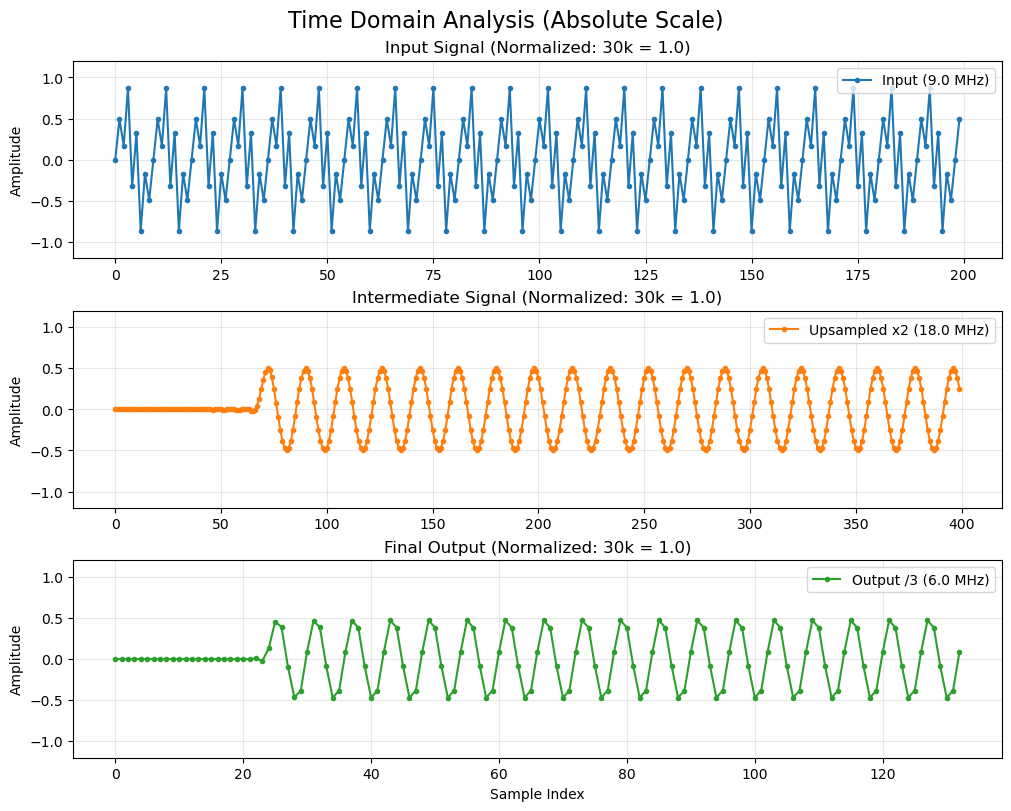

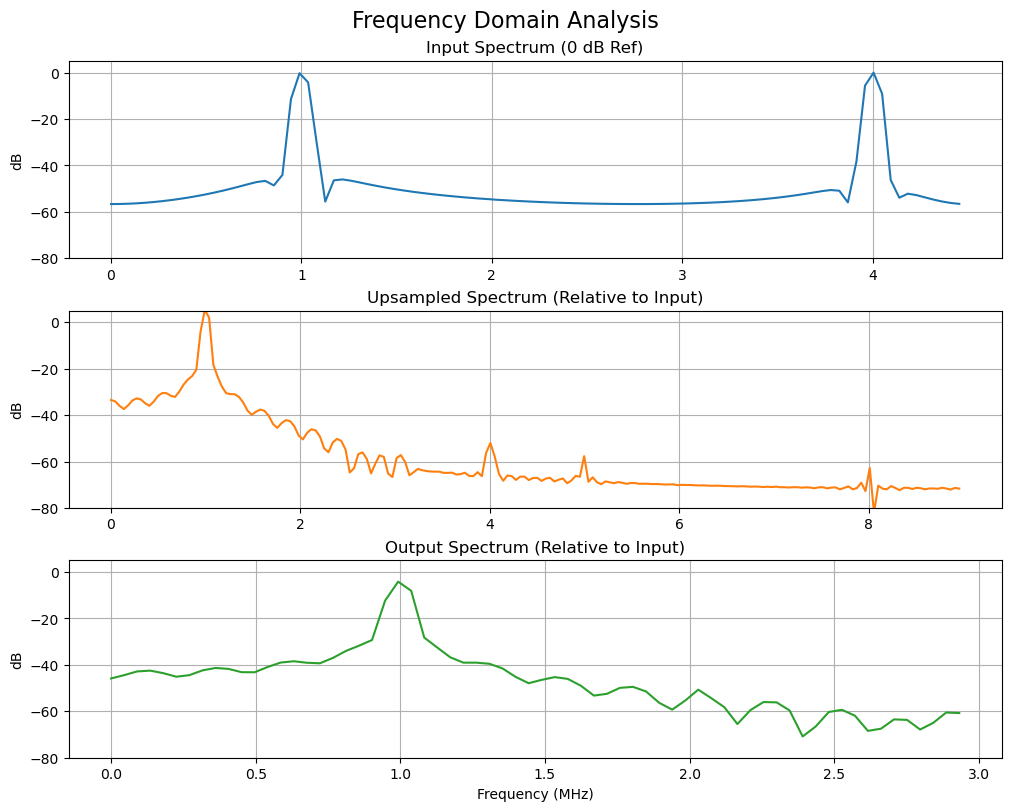

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration matches your VHDL/SV testbench
FILENAME = "resampler_output.txt"
FS_IN = 9.0e6       # 9 MHz Input
L = 2
M = 3
FS_MID = FS_IN * L  # 18 MHz
FS_OUT = FS_MID / M # 6 MHz

# HARDCODED NORMALIZATION
NORM_FACTOR = 30000.0

def parse_file(filename):
    data_in = []
    data_mid = []
    data_out = []

    print(f"Reading {filename}...")
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith("IN:"):
                    val = int(line.split()[-1])
                    data_in.append(val)
                elif line.startswith("MID:"):
                    val = int(line.split()[-1])
                    data_mid.append(val)
                elif line.startswith("OUT:"):
                    val = int(line.split()[-1])
                    data_out.append(val)
    except FileNotFoundError:
        print(f"Error: Could not find {filename}. Run the simulation first.")
        exit()

    return np.array(data_in), np.array(data_mid), np.array(data_out)

def plot_time_domain(sig_in, sig_mid, sig_out):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)
    
    # 1. Input Plot
    ax1.plot(sig_in, '.-', color='tab:blue', label=f'Input ({FS_IN/1e6} MHz)')
    ax1.set_title(f"Input Signal (Normalized: 30k = 1.0)")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="upper right")
    ax1.set_ylabel("Amplitude")
    # Fixed Y limits to show range clearly
    ax1.set_ylim([-1.2, 1.2]) 

    # 2. Intermediate Plot
    ax2.plot(sig_mid, '.-', color='tab:orange', label=f'Upsampled x2 ({FS_MID/1e6} MHz)')
    ax2.set_title(f"Intermediate Signal (Normalized: 30k = 1.0)")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper right")
    ax2.set_ylabel("Amplitude")
    ax2.set_ylim([-1.2, 1.2]) 

    # 3. Output Plot
    ax3.plot(sig_out, '.-', color='tab:green', label=f'Output /3 ({FS_OUT/1e6} MHz)')
    ax3.set_title(f"Final Output (Normalized: 30k = 1.0)")
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="upper right")
    ax3.set_ylabel("Amplitude")
    ax3.set_xlabel("Sample Index")
    ax3.set_ylim([-1.2, 1.2]) 

    plt.suptitle("Time Domain Analysis (Absolute Scale)", fontsize=16)

def plot_frequency_domain(sig_in, sig_mid, sig_out):
    
    def get_fft_db(sig, fs):
        window = np.hamming(len(sig))
        sig_windowed = sig * window
        fft_val = np.fft.fft(sig_windowed)
        fft_freq = np.fft.fftfreq(len(sig), 1/fs)
        
        half_n = len(sig) // 2
        fft_val = fft_val[:half_n]
        fft_freq = fft_freq[:half_n]
        
        # dB Calculation
        mag = 20 * np.log10(np.abs(fft_val) + 1e-12)
        return fft_freq, mag

    # Calculate FFTs
    f_in, mag_in = get_fft_db(sig_in, FS_IN)
    f_mid, mag_mid = get_fft_db(sig_mid, FS_MID)
    f_out, mag_out = get_fft_db(sig_out, FS_OUT)
    
    # Normalize Spectrum Plots to the INPUT's peak
    # This preserves the gain relationships between stages
    ref_level = np.max(mag_in)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

    ax1.plot(f_in/1e6, mag_in - ref_level, color='tab:blue')
    ax1.set_title(f"Input Spectrum (0 dB Ref)")
    ax1.set_ylabel("dB")
    ax1.grid(True)
    ax1.set_ylim(bottom=-80, top=5)

    ax2.plot(f_mid/1e6, mag_mid - ref_level, color='tab:orange')
    ax2.set_title(f"Upsampled Spectrum (Relative to Input)")
    ax2.set_ylabel("dB")
    ax2.grid(True)
    ax2.set_ylim(bottom=-80, top=5)

    ax3.plot(f_out/1e6, mag_out - ref_level, color='tab:green')
    ax3.set_title(f"Output Spectrum (Relative to Input)")
    ax3.set_xlabel("Frequency (MHz)")
    ax3.set_ylabel("dB")
    ax3.grid(True)
    ax3.set_ylim(bottom=-80, top=5)

    plt.suptitle("Frequency Domain Analysis", fontsize=16)

# --- Main Execution ---
if __name__ == "__main__":
    s_in_raw, s_mid_raw, s_out_raw = parse_file(FILENAME)
    
    print(f"Samples Read -> In: {len(s_in_raw)}, Mid: {len(s_mid_raw)}, Out: {len(s_out_raw)}")

    if len(s_in_raw) > 0:
        print(f"Normalizing all signals by Fixed Factor: {NORM_FACTOR}")

        # --- FIXED NORMALIZATION ---
        s_in = s_in_raw / NORM_FACTOR
        s_mid = s_mid_raw / NORM_FACTOR
        s_out = s_out_raw / NORM_FACTOR

        plot_time_domain(s_in[:200], s_mid[:400], s_out[:150]) 
        plot_frequency_domain(s_in, s_mid, s_out)
        
        plt.show()

